<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 15


In [224]:
import sys
sys.path.append("../")

In [225]:
from itertools import cycle, islice
import numpy as np

In [226]:
from sklearn import mixture
from sklearn import metrics
from pomegranate import *

In [227]:
from scipy.stats import kde
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [228]:
from helpers import read_configuration_file, INFO, WARNING
from train import main
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [229]:
sns.set(color_codes=True)

In [230]:
def load_data_file(filename):

    with open(filename) as file:
        context = file.read()
        size = len(context)
        arraystr= context[1:size-1]
        arraystr = arraystr.split(',')
        region_means = [float(item) for item in arraystr]
        return region_means

In [231]:
# change the paths here accordingly 

wga_mean_tuf_I_file = "/home/david/Desktop/wga_windows_mean_0_TUF_DETAIL_I.txt"
no_wga_mean_tuf_I_file = "/home/david/Desktop/no_wga_windows_mean_0_TUF_DETAIL_I.txt"
#gc_tuf_I_file = "/home/david/Desktop/windows_gc_0_TUF_DETAIL_I.txt"

#wga_mean_tuf_II_file = "/home/a/ag568/wga_windows_mean_0_TUF_DETAIL_II.txt"
#no_wga_mean_tuf_II_file = "/home/a/ag568/no_wga_windows_mean_0_TUF_DETAIL_II.txt"
#gc_tuf_II_file = "/home/a/ag568/windows_gc_0_TUF_DETAIL_II.txt"

wga_mean_single_copy_deletion_file = "/home/david/Desktop/wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
no_wga_mean_single_copy_deletion_file = "/home/david/Desktop/no_wga_windows_mean_0_SINGLE_COPY_DELETION.txt"
#gc_single_copy_deletion_file = "/home/david/Desktop/windows_gc_0_SINGLE_COPY_DELETION.txt"

wga_mean_duplication_file = "/home/david/Desktop/wga_windows_mean_0_DUPLICATION.txt"
no_wga_mean_duplication_file = "/home/david/Desktop/no_wga_windows_mean_0_DUPLICATION.txt"
#gc_duplication_file = "/home/david/Desktop/windows_gc_0_DUPLICATION.txt"

wga_mean_delete_file = "/home/david/Desktop/wga_windows_mean_0_DELETE.txt"
no_wga_mean_delete_file = "/home/david/Desktop/no_wga_windows_mean_0_DELETE.txt"
#gc_delete_file = "/home/david/Desktop/windows_gc_0_DELETE.txt"

In [232]:
wga_mu_tuf_I = load_data_file(filename=wga_mean_tuf_I_file)
no_wga_mu_tuf_I = load_data_file(filename=no_wga_mean_tuf_I_file)
#gc_tuf_I = load_data_file(filename=gc_tuf_I_file)

In [233]:
wga_mu_single_copy_deletion = load_data_file(filename=wga_mean_single_copy_deletion_file)
no_wga_mu_single_copy_deletion = load_data_file(filename=no_wga_mean_single_copy_deletion_file)
#gc_single_copy_deletion = load_data_file(filename=gc_single_copy_deletion_file)

In [234]:
wga_mu_duplication = load_data_file(filename=wga_mean_duplication_file)
no_wga_mu_duplication = load_data_file(filename=no_wga_mean_duplication_file)
#gc_duplication = load_data_file(filename=gc_duplication_file)

In [235]:
wga_mu_delete = load_data_file(filename=wga_mean_delete_file)
no_wga_mu_delete = load_data_file(filename=no_wga_mean_delete_file)
#gc_delete = load_data_file(filename=gc_delete_file)

In [236]:
# mix the data

# WGA sample
wga_mu = []
#wga_mu.extend(wga_mu_tuf_I)
#wga_mu.extend(wga_mu_tuf_II)
wga_mu.extend(wga_mu_single_copy_deletion)
wga_mu.extend(wga_mu_duplication)
wga_mu.extend(wga_mu_delete)


# NO-WGA sample
no_wga_mu = []
#no_wga_mu.extend(no_wga_mu_tuf_I)
#no_wga_mu.extend(no_wga_mu_tuf_II)
no_wga_mu.extend(no_wga_mu_single_copy_deletion)
no_wga_mu.extend(no_wga_mu_duplication)
no_wga_mu.extend(no_wga_mu_delete)


# GC
#gc = []
#gc.extend(gc_tuf_I)
#gc.extend(gc_tuf_II)
#gc.extend(gc_single_copy_deletion)
#gc.extend(gc_duplication)
#gc.extend(gc_delete)

In [237]:
def make_data_array(wga_mu, no_wga_mu, gc, use_ratio, use_gc):
    data = []
    
    if use_ratio and use_gc:
        for no_wga_val, wga_val,gc_val in zip(no_wga_mu, wga_mu, gc):
            data.append([no_wga_val, wga_val, (wga_val + 1)/(no_wga_val + 1), gc_val])
    elif use_ratio:
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga,  (wga + 1)/(no_wga + 1)])
    elif use_gc:
        
        for no_wga_val, wga_val , gc_val in zip(no_wga_mu, wga_mu,  gc):
            data.append([no_wga_val, wga_val, gc_val])
    else:
        
        for no_wga, wga  in zip(no_wga_mu, wga_mu):
            data.append([no_wga, wga ])
        
    return data

In [238]:
def gmm_clustering(clusters, data, cov_type, tol, max_itrs, 
                   n_init, no_wga_mu, wga_mu, xlim, ylim, nbins=80 ):
    
    #for nclusters in clusters:
    
        print("Number of clusters ", clusters)
        gmm = mixture.GaussianMixture(n_components=clusters,
                                      covariance_type=cov_type,
                                      tol=tol, max_iter=max_itrs,
                                      n_init=n_init)
        gmm.fit(data)
        print("Converged: ", gmm.converged_)
        print("BIC: ", gmm.bic(data))
        labels = gmm.predict(data)
        
        print("Len of labels: ", len(labels))

        colors = np.array(['green', 'blue', 'red', 'yellow', 'pink'])

        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        colors = colors[labels]
       
        plt.scatter(no_wga_mu, wga_mu,  color=colors)
        
        #kernel= kde.gaussian_kde(np.vstack([no_wga_mu, wga_mu]))
        #xi, yi = np.mgrid[min(no_wga_mu):max(no_wga_mu):nbins*1j, 
        #                  min(wga_mu):max(wga_mu):nbins*1j]
        
        #zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        
        #plt.contour(xi, yi, zi.reshape(xi.shape), 24 )
        
        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()
        
        # map that holds the association between the
        # component color and component index
        
        color_comp_assoc = {}
        for label, color in zip(labels, colors):
            if color in color_comp_assoc.keys():
                assert color_comp_assoc[color][0] == label
                color_comp_assoc[color][1] += 1
            else:
                color_comp_assoc[color] = [label, 1]
        
        return gmm, labels, color_comp_assoc

## Cluster the reference data

In [239]:
# Dictionay that holds the states for the HMM 
states={}

In [240]:
data = make_data_array(wga_mu=wga_mu, 
                       no_wga_mu=no_wga_mu, gc=None, 
                       use_ratio=False, use_gc=False)

data = np.array(data)

assert data.shape == (len(wga_mu), 2)

Number of clusters  5
Converged:  True
BIC:  154276.19190340413
Len of labels:  11741


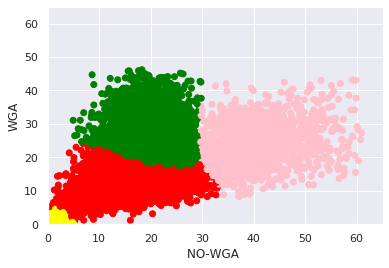

In [241]:
gmm, labels, color_comp_assoc = gmm_clustering(clusters=5, data=data, tol=1.0e-5, 
                                                 cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=no_wga_mu, wga_mu=wga_mu,
                                                 xlim=(0., 65.0),
                                                 ylim=(0., 65.0))

In [242]:
print("Color-cluster association", color_comp_assoc)


Color-cluster association {'red': [2, 5737], 'green': [0, 4141], 'pink': [4, 1288], 'yellow': [3, 355], 'blue': [1, 220]}


This depends on the clustering above so we need to make sure that colors do align

In [243]:
means = gmm.means_

for i in range(len(means)):
    print("{0} Component {1} means {2} ".format(INFO, i , means[i]))

covariances = gmm.covariances_

INFO: Component 0 means [19.64184703 23.31633875] 
INFO: Component 1 means [1.39214213e-20 1.39112068e-20] 
INFO: Component 2 means [16.65721085 13.75234546] 
INFO: Component 3 means [0.95877759 0.97106287] 
INFO: Component 4 means [39.63273133 24.28365303] 


In [244]:
states_map = {"Duplication": 4, "Normal-I": 2, 
              "Normal-II": 0, "Deletion": 3}

In [245]:


for state in states_map:
    name = state
    idx = states_map[state]
    
    # change the order of the means to match the order of the
    # data we will retrieve below in the prediction step
    mu_no_wga = means[idx][0]
    mu_wga = means[idx][1]
    mu = np.array([mu_wga, mu_no_wga])
    cov = covariances[idx]
    cov = np.array([[cov[1], 0.0], [0.0, cov[0]]])

    states[name]  = State(MultivariateGaussianDistribution(means=mu,
                                                       covariance=cov), name=name)
    
    #print(states[name])
    #print(mu)


### Cluster for TUF

Simply use the ref TUF I region to extract the distribution.

In [246]:
tuf_wga_mu = []
tuf_wga_mu.extend(wga_mu_tuf_I)

tuf_no_wga_mu = []
tuf_no_wga_mu.extend(no_wga_mu_tuf_I)

In [247]:
tuf_data = make_data_array(wga_mu=tuf_wga_mu, 
                       no_wga_mu=tuf_no_wga_mu, gc=None, 
                       use_ratio=True, use_gc=False)

tuf_data = np.array(tuf_data)

assert tuf_data.shape == (len(tuf_wga_mu), 3)

Number of clusters  3
Converged:  True
BIC:  15265.066934410512
Len of labels:  1231


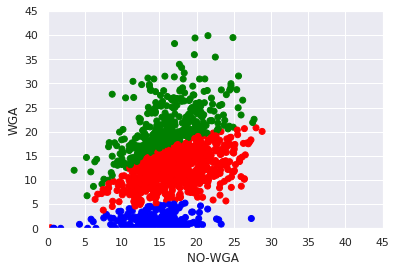

In [248]:
gmm_tuf, labels_tuf, color_comp_assoc_tuf = gmm_clustering(clusters=3, data=tuf_data, tol=1.0e-5, cov_type='diag',
                                                 max_itrs=300, n_init=1,
                                                 no_wga_mu=tuf_no_wga_mu, 
                                                 wga_mu=tuf_wga_mu,
                                                 xlim=(0., 45.0),
                                                 ylim=(0., 45.0))

In [249]:
print("Color-cluster association for TUF", color_comp_assoc_tuf)

Color-cluster association for TUF {'green': [0, 372], 'red': [2, 676], 'blue': [1, 183]}


In [250]:
tuf_idx = 1

In [251]:
tuf_means = gmm_tuf.means_

print("TUF means: ", tuf_means[tuf_idx])

tuf_cov = gmm_tuf.covariances_

tuf_mu_no_wga = tuf_means[tuf_idx][0]
tuf_mu_wga = tuf_means[tuf_idx][1]
tuf_mu = np.array([tuf_mu_wga, tuf_mu_no_wga])
tuf_cov = tuf_cov[tuf_idx]
tuf_cov = np.array([[tuf_cov[1], 0.0], [0.0, tuf_cov[0]]])
name = "TUF"
states[name]  = State(MultivariateGaussianDistribution(means=tuf_mu,
                                                       covariance=tuf_cov), name=name)

#print(states[name])

TUF means:  [14.22024699  1.73461219  0.19151063]


## Apply HMM

In [252]:
# load the configuration
configuration = read_configuration_file("../config.json")

In [253]:
hmm_config = configuration["HMM"]

In [254]:
hmm_states = hmm_config["states"]

In [255]:
hmm_transitions =  hmm_config["transitions"]

### Train HMM

In [256]:
gap_state = None
gap_state_dist = None


In [257]:
if configuration["remove_windows_with_gaps"] == False:
    
    name="GAP_STATE"
    
    # we have a gap state then add it
    gap_windows_dist = configuration["gap_windows_dist"]
    gap_state_dist = get_dist_list(dists_name=[gap_windows_dist["name"],
                                               gap_windows_dist["name"]],
                                               params={"uniform_params":gap_windows_dist["config"]["parameters"]})

    gap_state = \
            State(IndependentComponentsDistribution(gap_state_dist), 
                  name=name)
    states[name] = gap_state

In [258]:
print("{0} Number of states: {1}".format(INFO, len(states)))
for state in states:
    print(state)

INFO: Number of states: 6
Duplication
Normal-I
Normal-II
Deletion
TUF
GAP_STATE


In [259]:
# print info about the states
for name in states:
    state = states[name]
    print("{0} State: {1}".format(INFO, state.name))
    state_map = json.loads(str(state))
    print("{0} Distributions: {1}".format(INFO,
                                          state_map["distribution"]))

# create the HMM
hmm_model = HiddenMarkovModel(name=hmm_config["name"],
                              start=None, end=None)

states_list = []
for state in states:
    states_list.append(states[state])
hmm_model.add_states(states_list)

INFO: State: Duplication
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[24.283653032423455, 39.63273132854279], [[39.47163760525268, 0.0], [0.0, 71.54458934680895]]], 'frozen': False}
INFO: State: Normal-I
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[13.75234545570497, 16.657210853247882], [[19.023153578726667, 0.0], [0.0, 31.48407094795221]]], 'frozen': False}
INFO: State: Normal-II
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[23.31633875033319, 19.641847027011423], [[52.48899030298071, 0.0], [0.0, 19.60434473752156]]], 'frozen': False}
INFO: State: Deletion
INFO: Distributions: {'class': 'Distribution', 'name': 'MultivariateGaussianDistribution', 'parameters': [[0.9710628747441364, 0.9587775899741234], [[1.1058669708666904, 0.0], [0.0, 1.1947898297603778]]], 'frozen': False}
INFO: State: TUF
INFO: Distr

In [260]:
start_prob = 1.0/len(states)
hmm_config["states"]={}

for state in states:
    hmm_config["states"][state] = {"start_prob":start_prob}

In [261]:
print("Startring probabilities....")
for state in states:
    print("State: {0}, probability: {1} ".format(state,hmm_config["states"][state]["start_prob"]))
    

Startring probabilities....
State: Duplication, probability: 0.16666666666666666 
State: Normal-I, probability: 0.16666666666666666 
State: Normal-II, probability: 0.16666666666666666 
State: Deletion, probability: 0.16666666666666666 
State: TUF, probability: 0.16666666666666666 
State: GAP_STATE, probability: 0.16666666666666666 


Form the transition probabilities

In [262]:
self_trans = 0.95
off_trans = 0.05/(len(states) - 1)
hmm_config["transitions"]={}

for state_i in states:
    for state_j in states:
        state_name = state_i + "-" + state_j
        if state_i == state_j:
            hmm_config["transitions"][state_name] = self_trans
        else:
            hmm_config["transitions"][state_name] = off_trans

In [263]:
for state in states:
    prob = hmm_config["states"][state]["start_prob"]
    hmm_model.add_transition(hmm_model.start, states[state], prob)

# add transitions for every state
# to another this will create a dense HMM
for state_i in states:
    for state_j in states:
        if state_i + "-" + state_j in hmm_config["transitions"]:
                prob =hmm_config["transitions"][state_i + "-" + state_j]
                hmm_model.add_transition(states[state_i], states[state_j], prob)
        else:
                print("{0} Transition from state"
              " {1} to state {2} is not specified".format(WARNING,
                                                          state_i,
                                                          state_j))



In [264]:
# finally we need to bake
hmm_model.bake(verbose=True)

## HMM Predict

In [265]:
#%debug 
# load the region we want to use for prediction
region_file = "/home/david/Desktop/region_0_GMM.txt"
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

INFO: Loading region from file: /home/david/Desktop/region_0_GMM.txt


In [266]:
# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

Sequence length:  186767


In [267]:
observations = []
for i in range(len(sequence)):
    observations.append(sequence[i][0])

print("Observation length: ", len(observations))

time_start = time.perf_counter()
viterbi_path = hmm_model.viterbi(observations)
time_end = time.perf_counter()
print("Done. Execution time"
          " {0} secs".format(time_end - time_start))
print("Log-probability of ML Viterbi path: ", viterbi_path[0])

# for each item in the sequence
# cache the index and state predicted
sequence_viterbi_state = []

if viterbi_path[1] is not None:
        print("Viterbi path length: ", len(viterbi_path[1]))

        filename="viterbi_path.txt"
        counter = 0
        with open(filename, 'w') as f:
            f.write(str(len(viterbi_path[1])-1) + "\n")
            for item in range(len(sequence)):

                if sequence[item][0] == (-999.0, -999.0):
                    counter += 1

                f.write(str(item)+ ":" + str(sequence[item][1]) + ":" + str(sequence[item][0]) + ":" + viterbi_path[1][item+1][1].name + "\n")
                sequence_viterbi_state.append((item, viterbi_path[1][item+1][1].name))
                
                #print("sequnce item: {0} state {1}".format(sequence[item], viterbi_path[1][item+1][1].name))
        print("There should be {0} gaps".format(counter))
else:
        print("Viterbi path is impossible for the given sequence")

Observation length:  186767
Done. Execution time 0.7681628780010215 secs
Log-probability of ML Viterbi path:  -1167795.6058636822
Viterbi path length:  186768
There should be 1438 gaps


In [268]:
#from sklearn.cluster import OPTICS

In [269]:
# compare with GMM
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  185329
Encountered gaps:  1438


In [270]:
#predict_labels = gmm.predict(no_gaps_obs)

In [271]:
#colors = np.array(['green', 'blue', 'red', 'yellow', 'pink'])

# add black color for outliers (if any)
#colors = np.append(colors, ["#000000"])
#colors = colors[predict_labels]
       
#plt.scatter(no_wga_obs, wga_obs,  color=colors)
        
#kernel= kde.gaussian_kde(np.vstack([no_wga_obs, wga_obs]))
#xi, yi = np.mgrid[min(no_wga_obs):max(no_wga_obs):nbins*1j, 
#                          min(wga_obs):max(wga_obs):nbins*1j]
        
#zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
#plt.contour(xi, yi, zi.reshape(xi.shape), 24 )
        
#plt.xlabel("NO-WGA ")
#plt.ylabel("WGA")
#plt.xlim(xlim)
#plt.ylim(ylim)
#plt.show()
        
# map that holds the association between the
# component color and component index
        
#color_comp_assoc = {}
#for label, color in zip(predict_labels, colors):
#    if color in color_comp_assoc.keys():
#        assert color_comp_assoc[color][0] == label
#        color_comp_assoc[color][1] += 1
#    else:
#        color_comp_assoc[color] = [label, 1]

In [272]:
#print("Color-cluster association", color_comp_assoc)

In [273]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0}

In [274]:
# collect counters for error statistics
for i, obs in enumerate(observations):
    
    # what dows the Viterbi path says
    viterbi_state = sequence_viterbi_state[i][1]
    if obs == (-999.0, -999.0):
        
        # if we predict that increase the success 
        # otherwise increase errors
        if viterbi_state == 'GAP_STATE':
            states_counter[viterbi_state] += 1
        else:
            states_counter["GAP_STATE_INCORRECT"] += 1
    else:
        states_counter[viterbi_state] += 1      

In [275]:
print(states_counter)

{'Duplication': 687, 'Normal-I': 94877, 'Normal-II': 76477, 'Deletion': 409, 'Single-Deletion': 0, 'TUF': 12879, 'GAP_STATE': 1438, 'GAP_STATE_INCORRECT': 0}


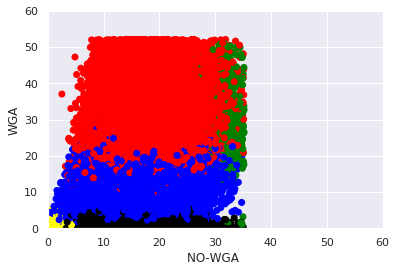

In [276]:
hmm_labels = []
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5}

for i, obs in enumerate(observations):
        if obs != (-999.0, -999.0):
            viterbi_state = sequence_viterbi_state[i][1]
            hmm_labels.append(hmm_states_to_labels[viterbi_state])


colors = np.array(['green', 'blue', 'red', 'yellow', 'pink', 'black'])

# add black color for outliers (if any)
#colors = np.append(colors, ["#000000"])
colors = colors[hmm_labels]
       
plt.scatter(no_wga_obs, wga_obs,  color=colors)
        
#kernel= kde.gaussian_kde(np.vstack([no_wga_obs, wga_obs]))
#xi, yi = np.mgrid[min(no_wga_obs):max(no_wga_obs):nbins*1j, 
#                          min(wga_obs):max(wga_obs):nbins*1j]
        
#zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
#plt.contour(xi, yi, zi.reshape(xi.shape), 24 )
        
plt.xlabel("NO-WGA ")
plt.ylabel("WGA")
plt.xlim(0.0, 60.0)
plt.ylim(0.0, 60.0)
plt.show()

color_comp_assoc_hmm = {}
for label, color in zip(hmm_labels, colors):
    if color in color_comp_assoc_hmm.keys():
        assert color_comp_assoc_hmm[color][0] == label
        color_comp_assoc_hmm[color][1] += 1
    else:
        color_comp_assoc_hmm[color] = [label, 1]

In [277]:
print("HMM labels color: ", color_comp_assoc_hmm)

HMM labels color:  {'black': [5, 12879], 'blue': [1, 94877], 'yellow': [3, 409], 'red': [2, 76477], 'green': [0, 687]}


State:  Duplication
Length: 687


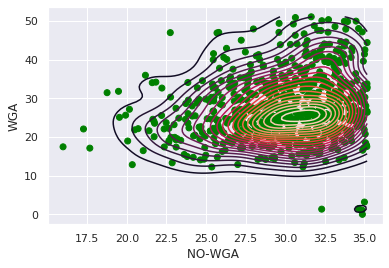

State:  Normal-I
Length: 94877


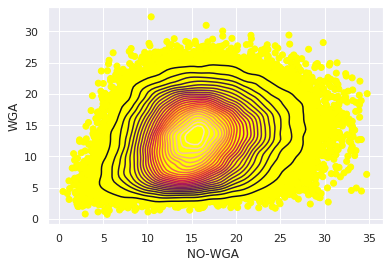

State:  Normal-II
Length: 76477


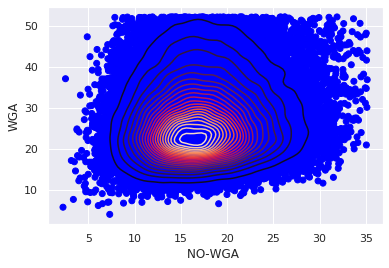

State:  Deletion
Length: 409


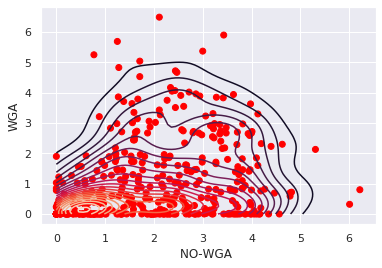

State:  Single-Deletion
For state: Single-Deletion could not plot empty observations
State:  TUF
Length: 12879


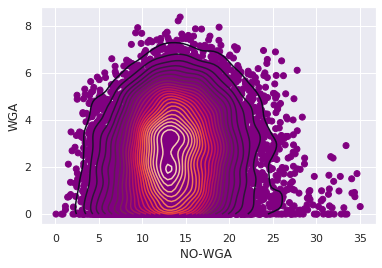

In [279]:
for label in hmm_states_to_labels:
    
    print("State: ", label)
    label_idx = hmm_states_to_labels[label]
    
    state_labels = []
    
    state_no_wga_obs = []
    state_wga_obs = []
    for i, item in enumerate(hmm_labels):
        if item == label_idx:
            state_labels.append(label_idx)
            state_no_wga_obs.append(no_wga_obs[i])
            state_wga_obs.append(wga_obs[i])
        #else:
        #    state_labels.append(10)
    
    colors = np.array(['green', 'yellow', 'blue', 'red', 'pink', 'purple'])
    
    # get the labels for this label
    
    
    if len(state_no_wga_obs) != 0:
        
        print("Length: {0}".format(len(state_no_wga_obs)))
        #print("Length state labels: {0}".format(len(state_labels)))
        
        colors = colors[state_labels]
    
        # plot the observations
        plt.scatter(state_no_wga_obs, state_wga_obs,  color=colors)
        
        kernel= kde.gaussian_kde(np.vstack([state_no_wga_obs, state_wga_obs]))
        xi, yi = np.mgrid[min(state_no_wga_obs):max(state_no_wga_obs):nbins*1j, 
                               min(state_wga_obs):max(state_wga_obs):nbins*1j]

        zi = kernel(np.vstack([xi.flatten(), yi.flatten()]))
        plt.contour(xi, yi, zi.reshape(xi.shape), 24 )

        plt.xlabel("NO-WGA ")
        plt.ylabel("WGA")
        #plt.xlim(0.0, 60.0)
        #plt.ylim(0.0, 60.0)
        plt.show()
    else:
        print("For state: {0} could not plot empty observations".format(label))
    